### Example notebook - Differential Gene Expression (Pathway Enrichment)

- title: "DGE-Pathways"
- author: "Margaret Paiva"
- output: R notebook

In [17]:
# Check your R version if packages are not compatible
R.version

In [4]:
# Install BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [3]:
# Install packages using BiocManager
for (pkg in c("limma", "fgsea")) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        BiocManager::install(pkg, update = FALSE, 
                             ask = FALSE, force = TRUE)
    }
}

In [2]:
suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(rjson))
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(DBI))
suppressPackageStartupMessages(library(DT))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(fgsea))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))

In [3]:
# In "gene_list.csv", define a list of genes of interest
gene_list  <- as.list(read.csv("gene_list.csv")$x)

In [52]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [ ]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$model  <- as.character(df$model)
df$log.tpm  <- as.numeric(df$log.tpm)
df$z  <- as.numeric(df$z)
head(df, 2)
print(dim(df))

### GSEA pathway enrichment analysis

I load an object previously generated here. The only file needed besides the API data above is pathways.gmt. You can download it from https://www.pathwaycommons.org/.

In [12]:
load("../data/RData_uncomp_20210714", verbose=TRUE)

Loading objects:
  cnv.db
  lcpm.list
  lrpkm.lst
  mut.db
  pathways.gmt
  pathways_namming
  rna.seq
  rna.seq.heme
  symbols.dt


To use GSEA for pathway enrichment analysis, a ranking data with genes ranked by the t or z statistics must be provided. Here, we can extract the statistics from the API data. For your own research, you can calculate the t statistics between genes using the `log.tpm` column of the API data.

In [54]:
ranks <- df %>% 
  dplyr::select(gene, z) %>% 
  na.omit() %>%
  deframe()
head(ranks, 2)

ACSM3      COPZ2 
-0.1693172 -0.9946150

Now, we have everything we need to perform pathway enrichment analysis.

In [55]:
fgseaRes <- suppressWarnings(fgsea(pathways = pathways.gmt,
     stats = ranks,
     nperm = 1000))
head(fgseaRes, 2)

pathway                                      pval       padj       ES       
1 http://identifiers.org/kegg.pathway/hsa00010 0.14717742 0.16200104 0.8098988
2 http://identifiers.org/kegg.pathway/hsa00030 0.03333333 0.04126214 0.9808693
  NES      nMoreExtreme size leadingEdge     
1 1.317346 72           2    FBP1   , ALDH3A1
2 1.307532 15           1    FBP1

- ES – enrichment score
- NES – normalized enrichment score

In [56]:
# Rank the pathways by the normalized enrichment scores
fgseaResTidy <- fgseaRes %>%
  as_tibble() %>%
  arrange(desc(NES))

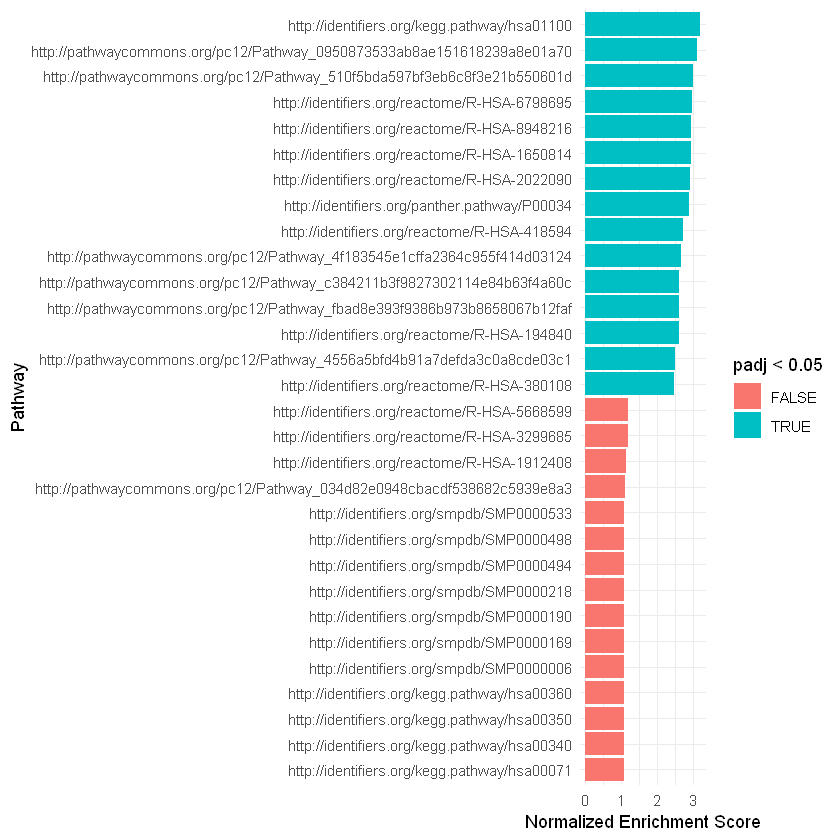

In [58]:
# Here, I rbind the top pathways and the bottom pathways to show the significant vs. the non-significant pathways
# You may want to pick only the top pathways to explore further
ggplot(rbind(head(fgseaResTidy, 15), tail(fgseaResTidy, 15)), 
       aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score") + 
  theme_minimal()